In [2]:
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10  # Change to CIFAR-10
import time

In [3]:
# Helper function to load a TensorRT engine
def load_trt_engine(engine_path):
    with open(engine_path, 'rb') as f:
        runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING))
        engine = runtime.deserialize_cuda_engine(f.read())
    return engine

In [4]:
# Prepare the TensorRT execution context
def create_context(engine):
    context = engine.create_execution_context()
    return context

In [5]:
# Load the TensorRT model
trt_engine_path = r'E:\MCW_local_assignments\RESNET\cifar10_tensorrt.trt'  # Replace with your TRT model path
engine = load_trt_engine(trt_engine_path)
context = create_context(engine)

# Load CIFAR-10 data
(_, _), (x_test, y_test) = cifar10.load_data()  # Change to CIFAR-10

# Normalize the image
x_test = x_test / 255.0

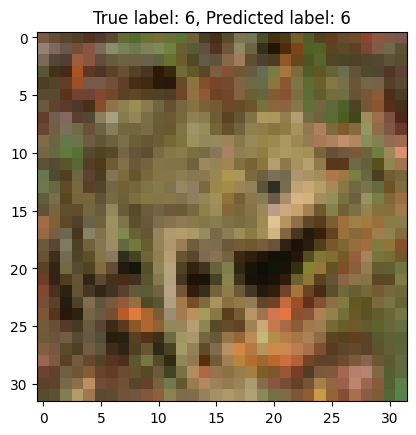

Prediction latency: 0.000635 seconds
The prediction is correct! Predicted: 6


In [8]:
# Pick a random image
random_index = np.random.randint(0, x_test.shape[0])
random_image = x_test[random_index]
true_label = y_test[random_index][0]  # Change to match CIFAR-10 label shape

# Prepare buffers
input_shape = (1, 32, 32, 3)
output_shape = (1, 10)  # Assuming 10 classes for CIFAR-10

input_data = np.expand_dims(random_image, axis=0).astype(np.float32)
input_data = np.ascontiguousarray(input_data)  # Ensure the array is contiguous

# Allocate buffers for inputs and outputs
d_input = cuda.mem_alloc(input_data.nbytes)
d_output = cuda.mem_alloc(np.empty(output_shape, dtype=np.float32).nbytes)
bindings = [int(d_input), int(d_output)]

# Copy input to device
cuda.memcpy_htod(d_input, input_data)

# Measure the time before prediction
start_time = time.time()

# Run inference
context.execute_v2(bindings)

# Measure the time after prediction
end_time = time.time()

# Copy output from device
output_data = np.empty(output_shape, dtype=np.float32)
cuda.memcpy_dtoh(output_data, d_output)

# Calculate the latency
latency = end_time - start_time

# Extract the predicted label
predicted_label = np.argmax(output_data)

# Plot the image
plt.imshow(random_image)
plt.title(f"True label: {true_label}, Predicted label: {predicted_label}")
plt.show()

# Print the latency
print(f"Prediction latency: {latency:.6f} seconds")

# Print whether the prediction is correct or not
if true_label == predicted_label:
    print(f"The prediction is correct! Predicted: {predicted_label}")
else:
    print(f"The prediction is incorrect. Predicted: {predicted_label}, True label: {true_label}")
